# **PLANO DE SAÚDE: XGBOOST**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler         # Balanceamento de classes
import xgboost as xgb                                          # XGBoost
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [ ]:
dados_plano = pd.read_table("Plano_Saude.txt", sep = "\t")

In [ ]:
# Reordenação de categorias da variável resposta
dados_plano['STATUS'] = pd.Categorical(dados_plano['STATUS'], categories = ['CancInvol', 'CancVol', 'Down', 'Mantem', 'Up'], ordered = True)

### Visualização da base de dados

In [ ]:
display(dados_plano)

,ID_CLIENTE,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,FLAG_MUDANCA_RESIDENCIA_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE,STATUS
0,CLI000001,7.7,0.11,6,4.4,3,0,Nao,0,2,78,Mantem
1,CLI000002,9.8,0.49,3,3.3,1,0,Nao,0,1,21,Mantem
2,CLI000003,6.2,0.12,4,6.4,1,0,Nao,0,0,1,Up
3,CLI000004,7.4,0.35,15,5.6,1,2,Nao,3,0,10,Mantem
4,CLI000005,0.3,0.25,26,3.5,2,2,Nao,0,1,89,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CLI099996,9.4,0.39,10,3.6,1,6,Nao,2,0,26,CancInvol
99996,CLI099997,9.2,0.25,3,6.3,2,0,Nao,1,0,42,Up
99997,CLI099998,9.6,0.09,5,8.0,2,2,Nao,1,0,23,Mantem
99998,CLI099999,5.2,0.43,2,5.9,1,0,Sim,0,0,33,Mantem


### Separação de features e target

In [ ]:
X = dados_plano.drop(columns = ['STATUS', 'ID_CLIENTE'])
y = dados_plano['STATUS']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [ ]:
X = pd.get_dummies(X, drop_first = True)

### Codificar variável resposta com valores numéricos (requisito do XGBClassifier)

In [ ]:
mapping = {
    'CancInvol': 0,
    'CancVol': 1,
    'Down': 2,
    'Mantem': 3,
    'Up': 4
}

y = y.map(mapping)

### Balanceamento de base de dados grande (undersampling)

In [ ]:
# Contagem de valores na variável resposta antes do balanceamento
y.value_counts()

,count
STATUS,
3,67000
4,13000
2,10000
0,6000
1,4000


In [ ]:
# Balanceamento
rus = RandomUnderSampler(random_state = 123)
X_sample, y_sample = rus.fit_resample(X, y)

In [ ]:
# Contagem de valores na variável resposta após o balanceamento
y_sample.value_counts()

,count
STATUS,
0,4000
1,4000
2,4000
3,4000
4,4000


### Modelo 1: XGBoost com otimização de hiperparâmetros via validação cruzada, com random search

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_child_weight': np.arange(1, 11),
    'gamma': np.arange(0, 1.1, 0.1)
}

In [ ]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC-OVR e k = 5 (EXECUÇÃO ONEROSA)
xgboost = xgb.XGBClassifier(random_state = 123)
cv = KFold(n_splits = 5, shuffle = True, random_state = 123)
scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(xgboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
random_search.fit(X_sample, y_sample)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=N...
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_child_weight': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC_OVR',
                   scoring={'AUC_OVR': 'roc_auc_ovr',
                            'balanced_accuracy': 'balanced_accuracy'})

In [ ]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 150, 'min_child_weight': 10, 'max_depth': 2, 'learning_rate': 0.23, 'gamma': 0.4}


In [ ]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC-OVR médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC_OVR', 'std_test_AUC_OVR', 'rank_test_AUC_OVR',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy']].sort_values(by = 'rank_test_AUC_OVR')
resultados_grid

,params,mean_test_AUC_OVR,std_test_AUC_OVR,rank_test_AUC_OVR,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy
93,"{'n_estimators': 150, 'min_child_weight': 10, ...",0.907015,0.001288,1,0.665149,0.003119,3
65,"{'n_estimators': 180, 'min_child_weight': 2, '...",0.907004,0.001282,2,0.665325,0.003950,2
16,"{'n_estimators': 180, 'min_child_weight': 3, '...",0.907001,0.001259,3,0.665749,0.004543,1
62,"{'n_estimators': 190, 'min_child_weight': 5, '...",0.906872,0.001417,4,0.664113,0.003522,5
8,"{'n_estimators': 190, 'min_child_weight': 1, '...",0.906756,0.001316,5,0.664222,0.004509,4
...,...,...,...,...,...,...,...
86,"{'n_estimators': 80, 'min_child_weight': 1, 'm...",0.885276,0.001703,96,0.626902,0.005783,96
37,"{'n_estimators': 40, 'min_child_weight': 8, 'm...",0.882863,0.001815,97,0.621680,0.005111,97
81,"{'n_estimators': 30, 'min_child_weight': 8, 'm...",0.867114,0.002507,98,0.606790,0.007689,98
45,"{'n_estimators': 130, 'min_child_weight': 9, '...",0.858966,0.002248,99,0.582011,0.007862,99


In [ ]:
# Modelo final a partir da melhor combinação de hiperparâmetros
xgboost_1 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_child_weight': np.arange(1, 11),
    'gamma': np.arange(0, 1.1, 0.1)
}

In [ ]:
# Validação cruzada estratificada aninhada com random search e otimização de AUC-OVR, k1 = 2 e k2 = 5 (EXECUÇÃO ONEROSA)
xgboost = xgb.XGBClassifier(random_state = 123)
inner_cv = KFold(n_splits = 2, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(xgboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
nested_scores = cross_validate(random_search, X = X_sample, y = y_sample, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC_OVR'].round(3))
print("Média de AUC-OVR: " + str(round(np.mean(nested_scores['test_AUC_OVR']), 3)))
print("D.P. de AUC-OVR: " + str(round(np.std(nested_scores['test_AUC_OVR']), 3)))

[0.906 0.905 0.909 0.908 0.907]
Média de AUC-OVR: 0.907
D.P. de AUC-OVR: 0.001


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.663 0.663 0.664 0.662 0.67 ]
Média de Acurácia Balanceada: 0.665
D.P. de Acurácia Balanceada: 0.003


### Aplicação do modelo final de XGBoost na base de dados



In [ ]:
# Atribuição das probabilidades preditas por categoria
xgboost_1.fit(X, y)
y_prob = pd.DataFrame(xgboost_1.predict_proba(X)[:,:], columns = xgboost_1.classes_)
dados_plano = pd.concat([dados_plano, y_prob], axis = 1)

In [ ]:
# Atribuição da categoria predita
dados_plano['y_pred'] = xgboost_1.predict(X)

In [ ]:
# Matriz de classificação absoluta: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'])

Predito,0,1,2,3,4
Observado,,,,,
CancInvol,3405,240,221,2117,17
CancVol,429,1762,333,1466,10
Down,276,424,2961,6317,22
Mantem,785,350,1152,62824,1889
Up,54,14,21,8185,4726


In [ ]:
# Matriz de classificação relativa: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'], normalize = 'index').round(2)

Predito,0,1,2,3,4
Observado,,,,,
CancInvol,0.57,0.04,0.04,0.35,0.00
CancVol,0.11,0.44,0.08,0.37,0.00
Down,0.03,0.04,0.30,0.63,0.00
Mantem,0.01,0.01,0.02,0.94,0.03
Up,0.00,0.00,0.00,0.63,0.36


### Importância das features do modelo final

In [ ]:
# Cálculo de medida de importância de Gini
importancias = xgboost_1.feature_importances_
features = X.columns

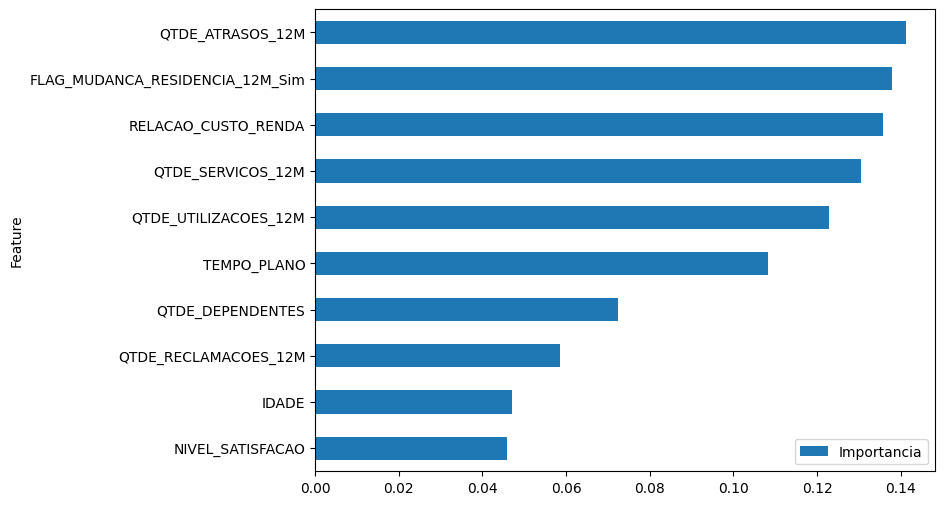

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(xgboost_1)
valores_shap = explainer(X)

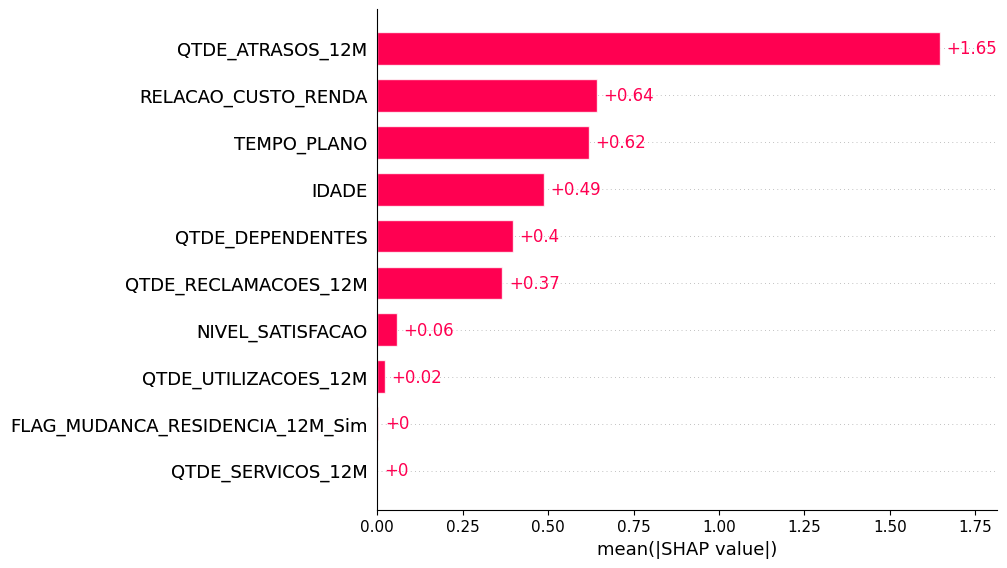

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'CancInvol'
shap.plots.bar(valores_shap[:,:,0])

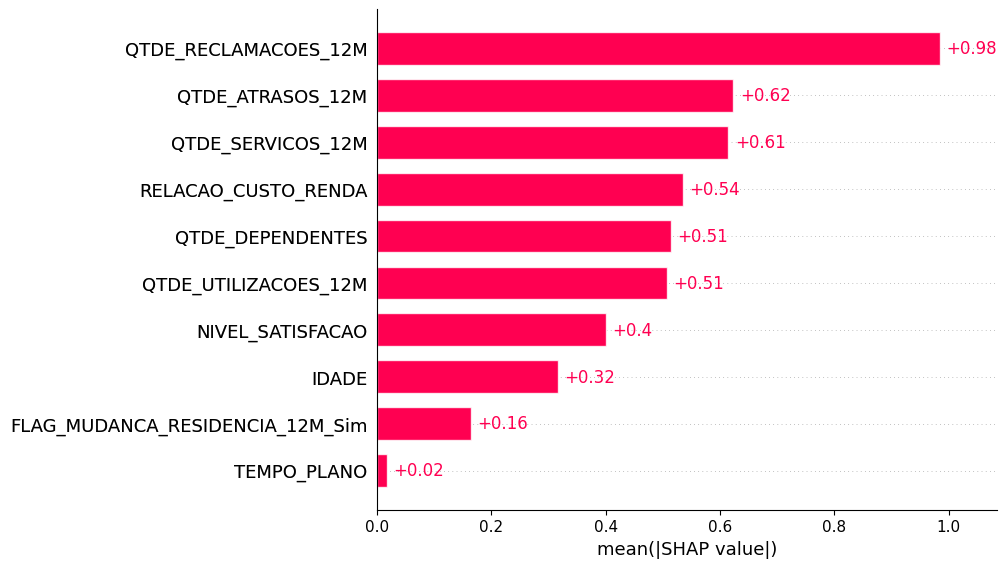

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'CancVol'
shap.plots.bar(valores_shap[:,:,1])

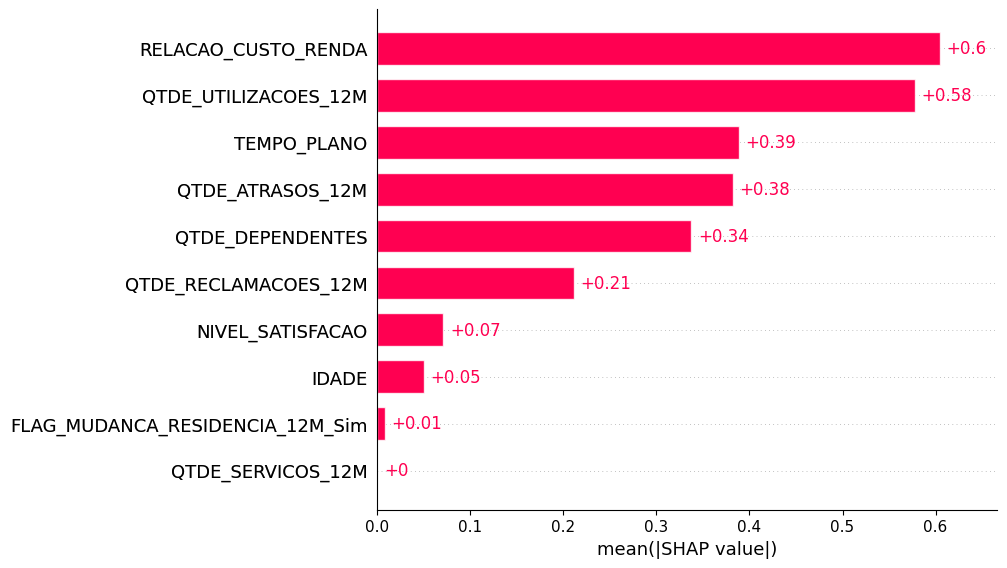

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Down'
shap.plots.bar(valores_shap[:,:,2])

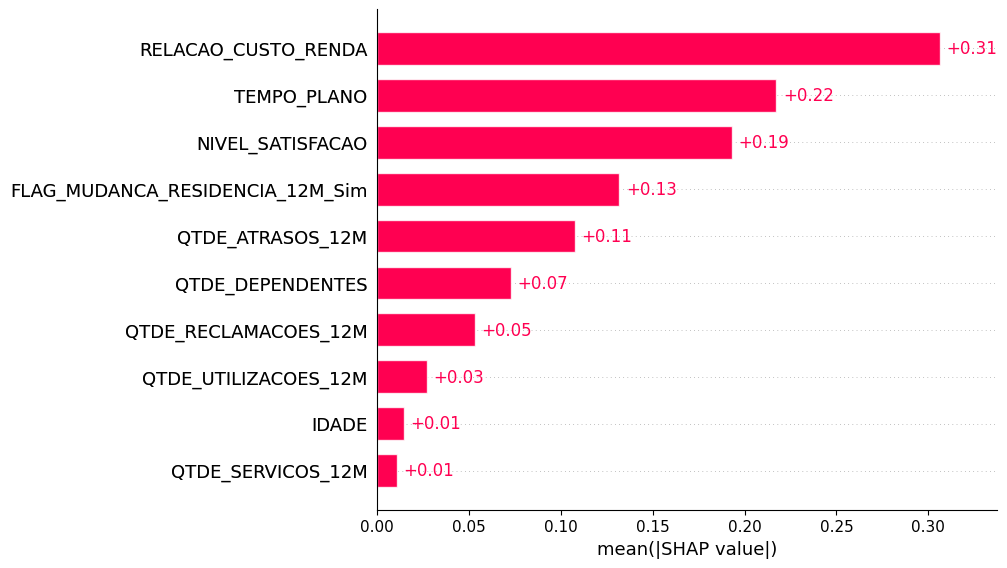

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Mantem'
shap.plots.bar(valores_shap[:,:,3])

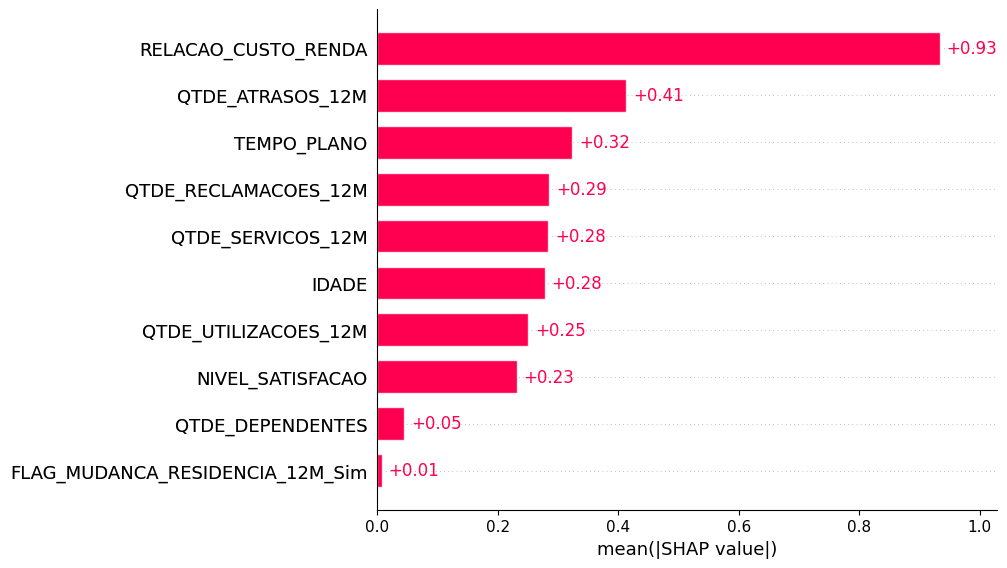

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Up'
shap.plots.bar(valores_shap[:,:,4])

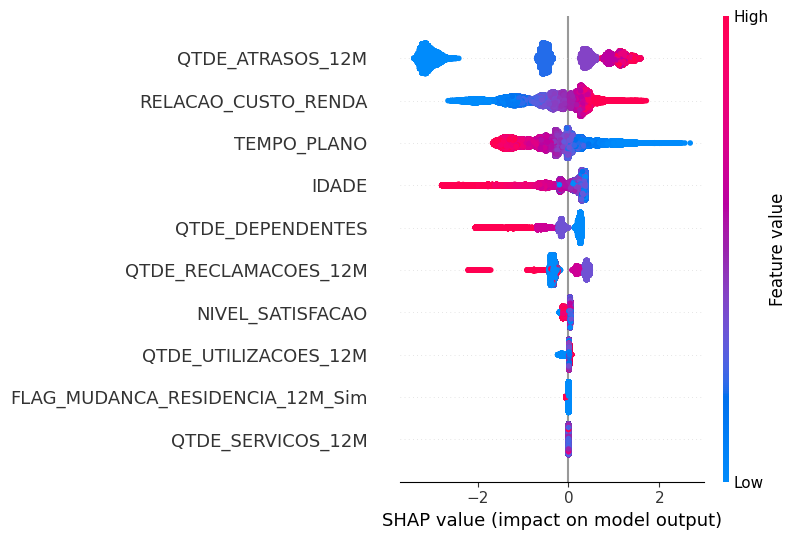

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'CancInvol'
shap.summary_plot(valores_shap[:,:,0])

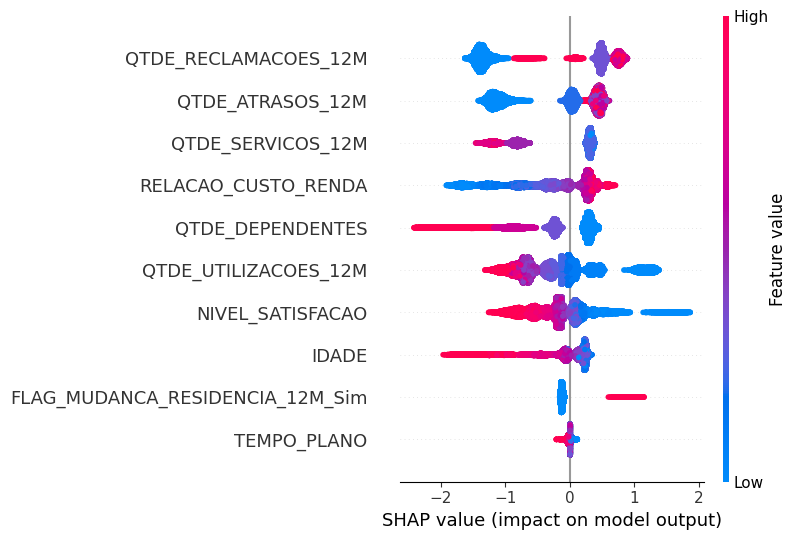

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'CancVol'
shap.summary_plot(valores_shap[:,:,1])

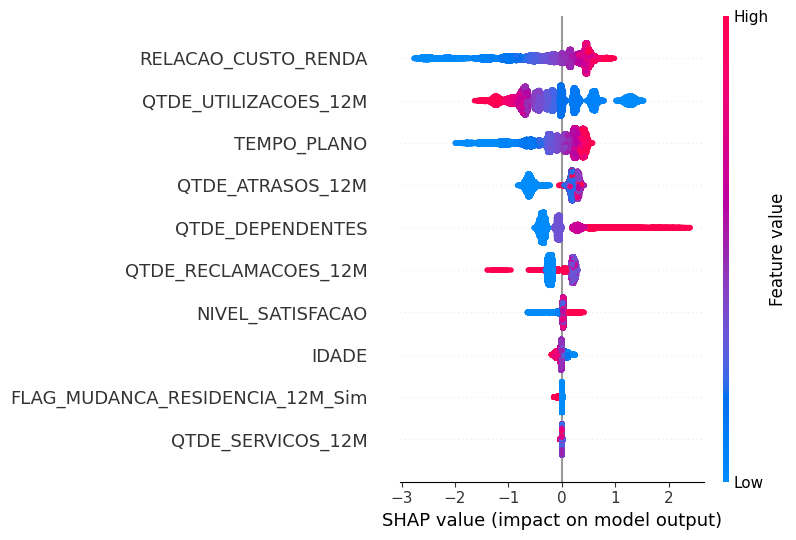

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Down'
shap.summary_plot(valores_shap[:,:,2])

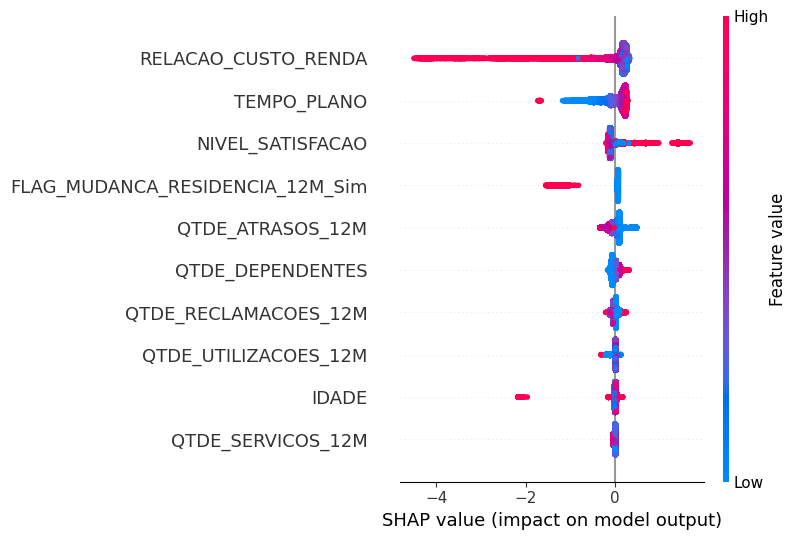

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Mantem'
shap.summary_plot(valores_shap[:,:,3])

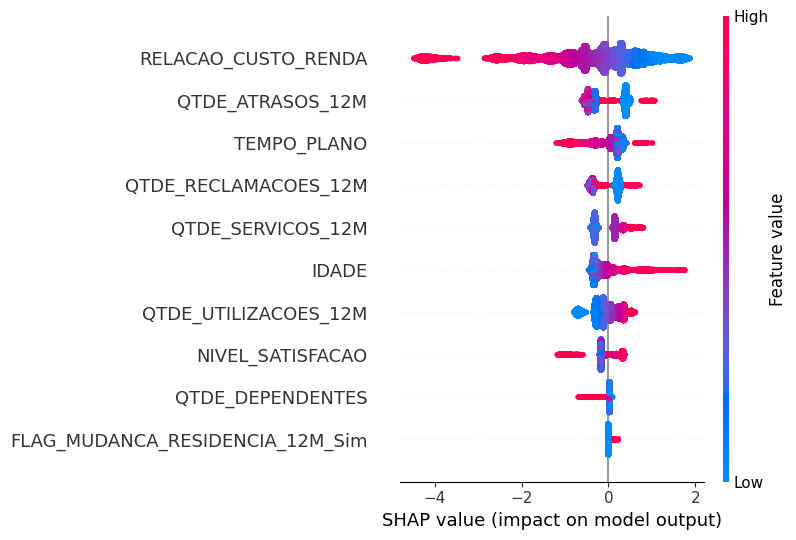

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Up'
shap.summary_plot(valores_shap[:,:,4])